In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, re


In [36]:
mission = "short"
scenario = 3
tache = "pctl"  # (snsr', 'rctl', 'ekf2', 'actl', 'pctl', 'hte', 'fmgr', 'cmdr', 'navr') ou 'all' pour tous les temps d'activation/end

In [37]:
# Chargement des fichiers
df_activation = pd.read_csv(f"../Data_Extraction/data_extracted/{mission}_mission/scenario{scenario}/activation_{tache}.csv")
df_end = pd.read_csv(f"../Data_Extraction/data_extracted/{mission}_mission/scenario{scenario}/end_{tache}.csv")
df_xtime = pd.read_csv(f"../Data_Extraction/data_extracted/{mission}_mission/scenario{scenario}/xtime_{tache}.csv")


# Préparation des données pour A(t) et D(t)

Dans cette section, on prépare les séries cumulatives **A(t)** (activations) et **D(t)** (ends) à partir des trois fichiers extraits :
- `activation.csv`
- `end.csv`
- `xtime.csv`

**Règles de construction :**

1. **Normalisation du temps**  
   - On soustrait la **première activation** `t0 = activation[0]` à **toutes** les activations et **tous** les ends.  
   - On **ajoute 0** comme premier temps pour les deux séries (repère visuel).

2. **Structure en escalier avec cumul (duplication des temps)**  
   - Les valeurs de `xtime` sont **cumulées** au fil des événements.  
   - Pour **chaque activation** normalisée `tᵢ`, on **duplique** `tᵢ` :  
     - premier point : cumul précédent,  
     - second point : cumul mis à jour (= cumul précédent + xtime courant).  
   - Pour les **ends**, même politique **à partir du premier vrai end**. Le `0` ajouté au début sert uniquement d’ancrage.  
   - Enfin, pour des raisons de normalisation, on **retire la dernière ligne de D** afin que **A et D terminent sur le même cumul**.

---

Cette construction produit deux séries prêtes à être tracées en **courbes en escalier** et à être utilisées dans nos algorithmes (détection de backlog, apprentissage de latence, convolution min-plus).


In [38]:
# --- Normalisation par rapport à la première activation ---
t0 = float(df_activation.iloc[0]["timestamp"])  # référence temporelle commune

act_times = (df_activation["timestamp"].astype(float) - t0).tolist()
end_times = (df_end["timestamp"].astype(float)        - t0).tolist()
xtimes    = df_xtime["timestamp"].astype(float).tolist()

**Construction des structures**

In [39]:
def build_step_series(event_times, xtimes, is_end=False):
    """
    Construit une série en escalier cumulée.
    - event_times : temps normalisés (list)
    - xtimes      : incréments (list) à cumuler
    - is_end      : si True, force D à commencer par (0,0)
    """
    pts = []
    if is_end:
        pts.append((0.0, 0.0))  # D commence à (0,0)

    y_prev = 0.0
    L = min(len(event_times), len(xtimes))

    for i in range(L):
        t_i = float(event_times[i])
        # cumul au lieu de valeur absolue
        y_curr = y_prev + float(xtimes[i])

        # marche : (t_i, ancien cumul) -> (t_i, nouveau cumul)
        pts.append((t_i, y_prev))
        pts.append((t_i, y_curr))

        y_prev = y_curr

    #if is_end: pts = pts[:-1]  # comme ça les A et les D finissent tout les deux sur le même y

    return pts

# Re-générer A et D (sans échantillonnage)
A_pts = build_step_series(act_times, xtimes, is_end=False)
D_pts = build_step_series(end_times, xtimes, is_end=True)


**Export des données**

In [40]:
df_A = pd.DataFrame(A_pts, columns=["t", "y"])
df_D = pd.DataFrame(D_pts, columns=["t", "y"])

df_A.to_csv("./A_pts.csv", index=False)
df_D.to_csv("./D_pts.csv", index=False)

print("Export terminé")

Export terminé


# Visualisation des données A(t) et D(t)

In [41]:
n_display = 15
#Mettez None pour affichier toutes les données
# Cette limitation va s'appliquer pour tout le notebook

In [42]:
if n_display is None:
    A_display = A_pts
    D_display = D_pts
else:
    A_display = A_pts[:n_display]
    D_display = D_pts[:n_display]

**Visualisation de A(t)**

In [43]:
def plot_escalier(tab, title):
    xs, ys = zip(*tab)
    plt.figure()
    plt.step(xs, ys, where="post")
    plt.xlabel("t")
    plt.ylabel(title)
    plt.title(title)
    plt.grid(True)
    plt.show()

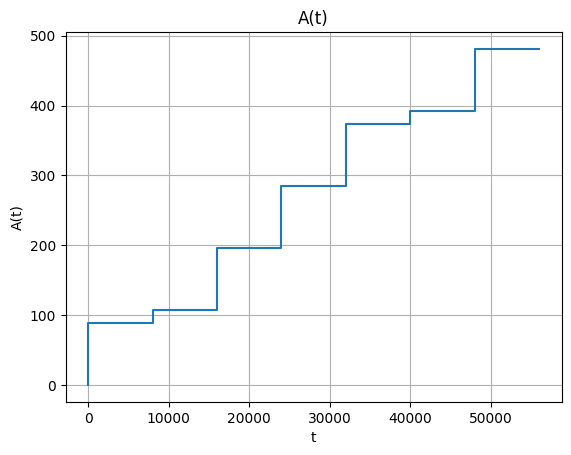

In [44]:
plot_escalier(A_display, "A(t)")

**Visualisation de D(t)**

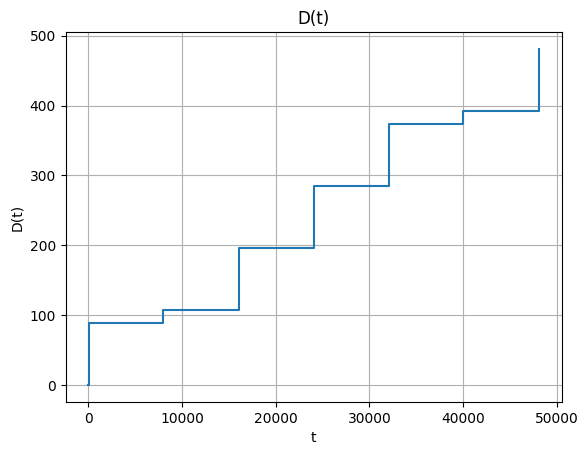

In [45]:
plot_escalier(D_display, "D(t)")

**Visualisation de A et D ensemble**

Pour **D(t)**, on n’utilise pas un escalier classique :  
- de la fin d’un segment horizontal de A → on trace un **segment linéaire** vers le prochain saut de D,  
- puis un **segment horizontal** jusqu’à la fin d’horizontale suivante de A.  

Tous les segments et points de D sont tracés en vert.  
Cela n’affecte pas l’application de nos algorithmes par la suite (ils utilisent directement les points de rupture de A et de D) ; c’est uniquement pour une visualisation plus fidèle aux principes du *network calculus* (un serveur qui sert les données progressivement).


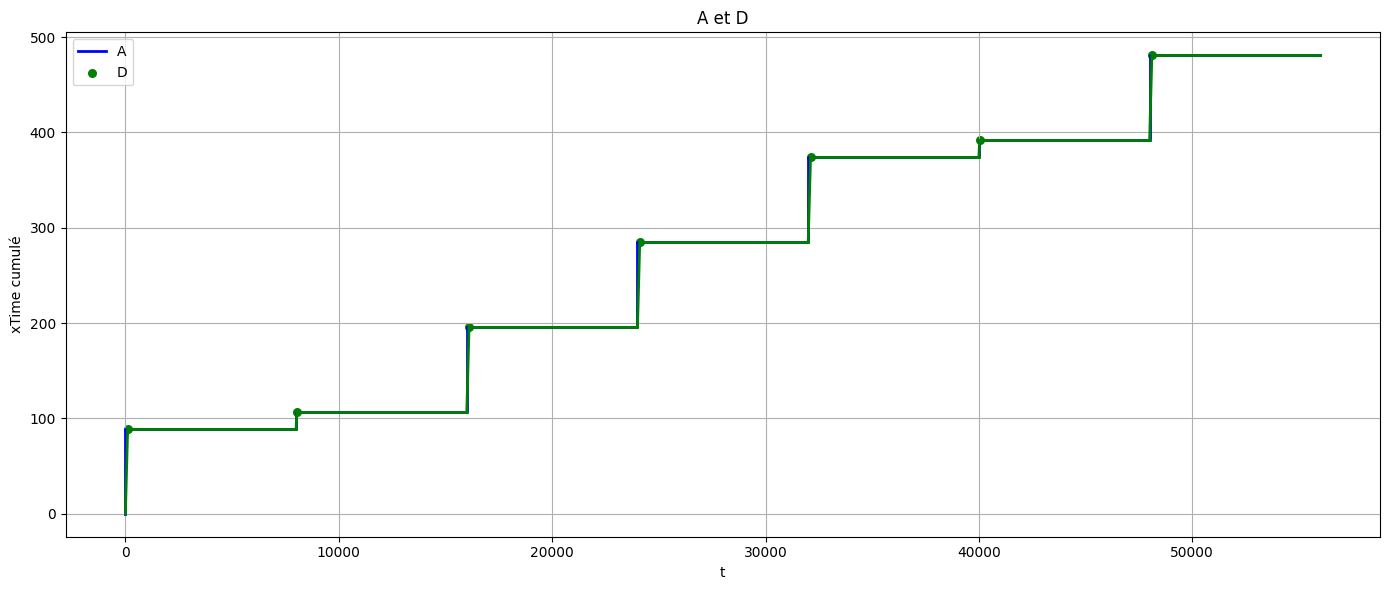

In [46]:
def plot_A_D(A_display, D_display, title):
    plt.figure(figsize=(14,6))

    # A en escalier
    xA, yA = zip(*A_display)
    plt.step(xA, yA, where="post", color="blue", linewidth=2, label="A")

    # Points fins d'horizontale de A
    A_ends = A_display[2::2]
    # Points sauts de D
    D_jumps = D_display[2::2]

    cur_x, cur_y = A_display[0]
    j = k = 0
    color_D = "green"

    def next_with_t_ge(lst, start_idx, t_ref):
        i = start_idx
        while i < len(lst) and lst[i][0] < t_ref:
            i += 1
        return i

    jump_x, jump_y = [], []

    while True:
        j = next_with_t_ge(D_jumps, j, cur_x)
        if j >= len(D_jumps):
            break
        dx, dy = D_jumps[j]
        plt.plot([cur_x, dx], [cur_y, dy], linewidth=2, color=color_D)
        jump_x.append(dx); jump_y.append(dy)

        k = next_with_t_ge(A_ends, k, dx)
        if k >= len(A_ends):
            cur_x, cur_y = dx, dy
            break
        ax, ay = A_ends[k]
        plt.plot([dx, ax], [dy, dy], linewidth=2, color=color_D)
        cur_x, cur_y = ax, dy
        j += 1
        k += 1

    if jump_x:
        plt.scatter(jump_x, jump_y, s=30, color=color_D, label="D")

    plt.xlabel("t")
    plt.ylabel("xTime cumulé")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_A_D(A_display, D_display, title="A et D")

# Apprentissage d'une courbe de service

## Courbe de service minimale

In [47]:
def cuts_with_line(A, r):
    """Vérifie si la droite y = r·t coupe la courbe cumulative A(t)"""
    n = len(A) - 1
    for i in range(1, n):
        T0, Y0 = A[i]
        T1, Y1 = A[i+1]
        v0 = r*T0 - Y0
        v1 = r*T1 - Y1
        if v0 * v1 < 0:
            return True
            
    return False

In [48]:
def minplus_conv_linear(A, r):
    """
    Calcule la convolution min-plus de A(t) avec une linéaire S(T) = r·t
    """
    # Préconditions de base : au moins 2 points, et r > 0.
    assert len(A) >= 2
    assert r > 0

    # A doit partir de (0,0)
    T0, A0 = A[0]
    TN, AN = A[-1]
    if T0 != 0.0 or A0 != 0.0:
        raise ValueError("A doit commencer en (0,0)")

    # si la droite y = r·t ne coupe pas A,
    # le résultat est trivial : soit la droite r·t, soit A lui-même (celui qui est en dessous).
    cuts = cuts_with_line(A, r)
    if not cuts:
        T1, A1 = A[1]
        # Si r·T1 < A1, la droite passe sous A dès le début -> (A CONV S)(t) = r·t
        if r*T1 < A1:
            return [(0.0, 0.0), (float(TN), float(r*TN))]
        else:
            # Sinon A est en dessous -> la convolution rend A inchangé
            return [(float(T), float(Y)) for (T, Y) in A]

    # Sinon, cas général : on balaye les ruptures de A et on maintient la marge M = min(Ai - r·Ti)
    out = [(0.0, 0.0)] 
    M = 0.0             #marge initiale (avec (0,0): Ai - r·Ti = 0)

    for i in range(1, len(A)):
        Ti, Ai = A[i]

        # On met à jour la marge minimalE.
        # (A CONV r·t)(Ti) = r·Ti + min_{u≤Ti}(A(u) - r·u)
        M = min(M, Ai - r*Ti)

        # Valeur au temps Ti avec la formule r·Ti + M.
        C = r*Ti + M
        K = Ti  # abscisse candidate

        # Si la candidate C n'égale pas le niveau de A en Ti (le saut), on recale
        # On projette l'intersection sur le segment [i-1, i] pour coller à la marche de A
        if C != Ai:
            Tim1, Aim1 = A[i-1]
            # Temps K où la droite r·t + M atteint Ai en remontant depuis le segment précédent.
            K = ((Ai - Aim1) / r) + Tim1
            C = Ai  # et on place la valeur pile sur la marche d'arrivée


        if K < out[-1][0]:
            K = out[-1][0]

        # On ajoute le point (K, C) à la de sortie.
        out.append((float(K), float(C)))
        
    return out


**Ici, nous pouvons fixer le taux de service R qu'on veux**

In [49]:
R = 0.015


In [50]:
A_conv = minplus_conv_linear(A_pts, R)
A_conv[:10]

[(0.0, 0.0),
 (5933.333333333334, 89.0),
 (7999.0, 89.0),
 (9199.0, 107.0),
 (16000.0, 107.0),
 (21933.333333333336, 196.0),
 (24000.0, 196.0),
 (29933.333333333336, 285.0),
 (32000.0, 285.0),
 (37933.333333333336, 374.0)]

In [51]:
df_Aconv = pd.DataFrame(A_conv, columns=["t", "y"])
df_Aconv.head(10)

,t,y
0,0.000000,0.0
1,5933.333333,89.0
2,7999.000000,89.0
3,9199.000000,107.0
4,16000.000000,107.0
5,21933.333333,196.0
6,24000.000000,196.0
7,29933.333333,285.0
8,32000.000000,285.0
9,37933.333333,374.0


**Export du résultat**

In [52]:
df_Aconv.to_csv("./A_conv.csv", index=False)

**Echantillonnage des données**:
La limite imposée auparavant (n_display) s'applique toujours

In [53]:
if n_display is None:
    A_disp = A_pts
    D_disp = D_pts
    Aconv_disp = A_conv
else:
    A_disp = A_pts[:n_display]
    D_disp = D_pts[:n_display]
    Aconv_disp = A_conv[:n_display]

**Visualisation de A, A*R.t et R.t**

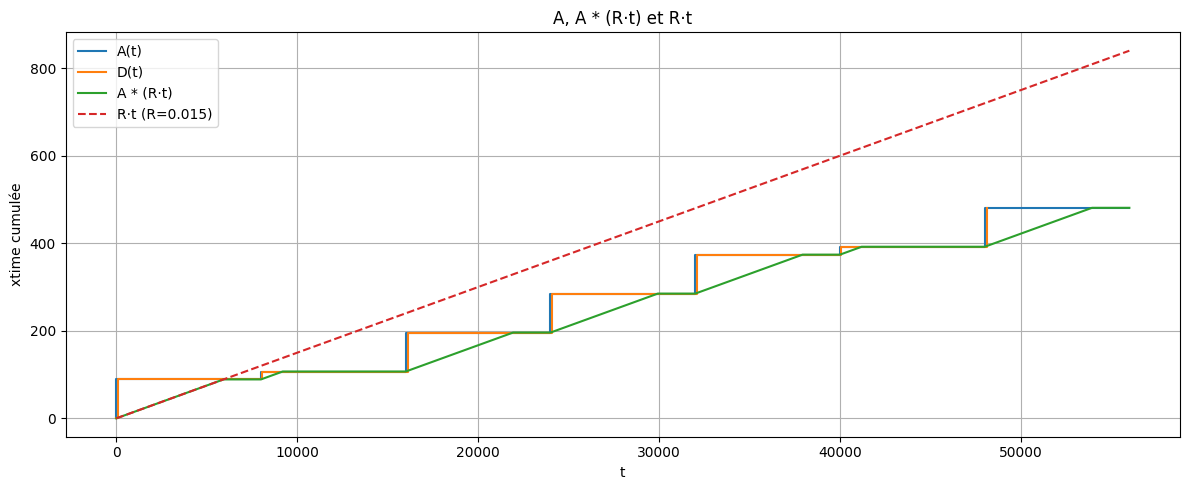

In [54]:
# Bornes temps pour R·t
t_max = max(A_disp[-1][0], Aconv_disp[-1][0]) if Aconv_disp else A_disp[-1][0]
Rt_disp = [(0.0, 0.0), (t_max, R * t_max)]

xA, yA = zip(*A_disp)
xD, yD = zip(*D_disp)
xC, yC = zip(*Aconv_disp) if Aconv_disp else ([], [])
xR, yR = zip(*Rt_disp)

plt.figure(figsize=(12,5))

plt.step(xA, yA, where="post", label="A(t)")
plt.step(xD, yD, where="post", label="D(t)")

if Aconv_disp:
    plt.plot(xC, yC, label="A * (R·t)")
plt.plot(xR, yR, linestyle="--", label=f"R·t (R={R})")

plt.xlabel("t")
plt.ylabel("xtime cumulée")
plt.title("A, A * (R·t) et R·t")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Calcul du meilleur T**

In [55]:
def best_T(A, D):
    """
    Calcule la latence minimale T* telle que D(t) >= A(t - T*) pour tout t
    """
    # Ensemble ordonné des niveaux y pertinents (tous les plateaux/sauts de A et de D)
    Y = sorted(set([Ai for _, Ai in A] + [Dj for _, Dj in D]))

    i = 0
    j = 0
    N = len(A) - 1
    M = len(D) - 1

    Delta = 0.0  # on stocke ici le max des (tD - tA) rencontrés

    for y in Y:
        # On avance i jusqu'à ce que A[i].y >= y
        while i < N and A[i][1] < y:
            i += 1

        Ai = A[i][1]; Ti = A[i][0]
        if Ai == y:
            # Si on est pile sur un palier égal à y : 
            #  s'il y a un plateau horizontal à y, prendre la fin du plateau (A[i+1].t),
            #  sinon rester sur Ti.
            if i < N and A[i+1][1] == y:
                tA = A[i+1][0]
            else:
                tA = Ti
        else:
            # Sinon, y est à l'intérieur du segment (i-1 -> i), on interpole du coup linéairement en temps
            Tim1, Aim1 = A[i-1]
            tA = Tim1 + (y - Aim1) * (Ti - Tim1) / (Ai - Aim1)

        # Même logique côté D : avancer j jusqu'à D[j].y >= y
        while j < M and D[j][1] < y:
            j += 1

        # Si on a vidé D et qu'on est toujours sous y -> D n'atteint jamais ce y : T* = +inf
        if j == M and D[j][1] < y:
            return float('inf')

        Dj = D[j][1]; Kj = D[j][0]
        if Dj == y:
            # Plateau exact sur D : prendre la fin du plateau si elle existe
            if j < M and D[j+1][1] == y:
                tD = D[j+1][0]
            else:
                tD = Kj
        else:
            # y est dans le segment (j-1 -> j), on interpole en temps
            Kj_m1, Dj_m1 = D[j-1]
            tD = Kj_m1 + (y - Dj_m1) * (Kj - Kj_m1) / (Dj - Dj_m1)

        # On garde le pire cas sur tous les y.
        Delta = max(Delta, tD - tA)

    return Delta 


In [56]:
T_star = best_T(A_conv, D_pts)
print(f"Latence minimale T* = {T_star}")

Latence minimale T* = 6913.0


In [57]:
if T_star == float("inf"):
    raise ValueError("T_star est infini : impossible de construire A décalé.")

A_conv_Beta = [(float(t + T_star), float(y)) for (t, y) in A_pts]

**Export**

In [58]:
df_A_conv_Beta = pd.DataFrame(A_conv_Beta, columns=["t", "y"])
df_A_conv_Beta.to_csv("./A_conv_Beta.csv", index=False)

**Echantillonnage des nouvelles données:**

In [59]:
if n_display is None:
    A_conv_Beta_disp = A_conv_Beta
else:
    A_conv_Beta_disp = A_conv_Beta[:n_display]


**Visualisation de A, D et A*beta**

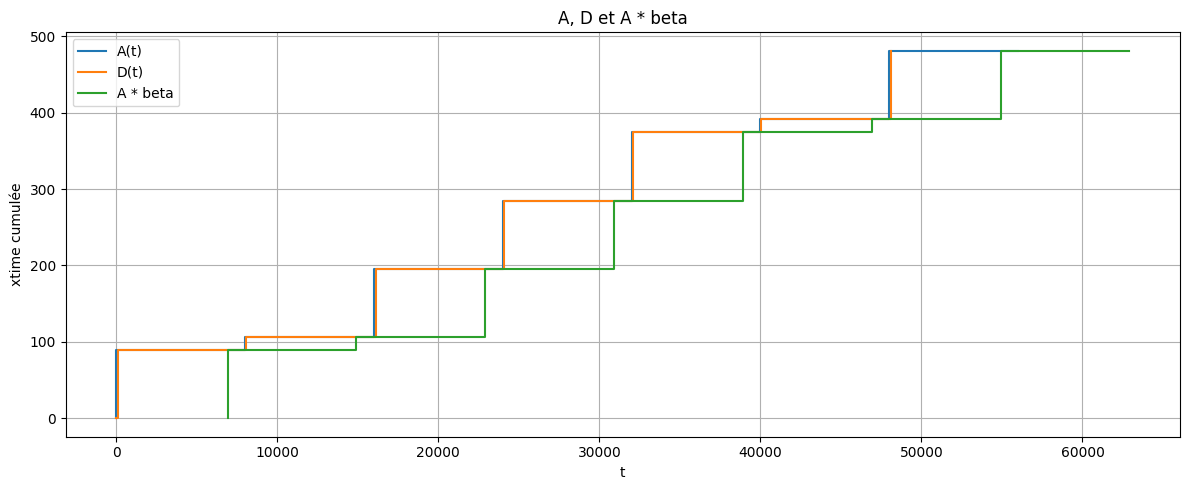

In [60]:
# Bornes temps pour R·t
t_max = max(A_disp[-1][0], Aconv_disp[-1][0]) if Aconv_disp else A_disp[-1][0]
Rt_disp = [(0.0, 0.0), (t_max, R * t_max)]

xA, yA = zip(*A_disp)
xD, yD = zip(*D_disp)
xC, yC = zip(*A_conv_Beta_disp) if A_conv_Beta_disp else ([], [])

plt.figure(figsize=(12,5))

plt.step(xA, yA, where="post", label="A(t)")
plt.step(xD, yD, where="post", label="D(t)")

if A_conv_Beta_disp:
    plt.plot(xC, yC, label="A * beta")

plt.xlabel("t")
plt.ylabel("xtime cumulée")
plt.title("A, D et A * beta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Visualisation de A, D et Beta**

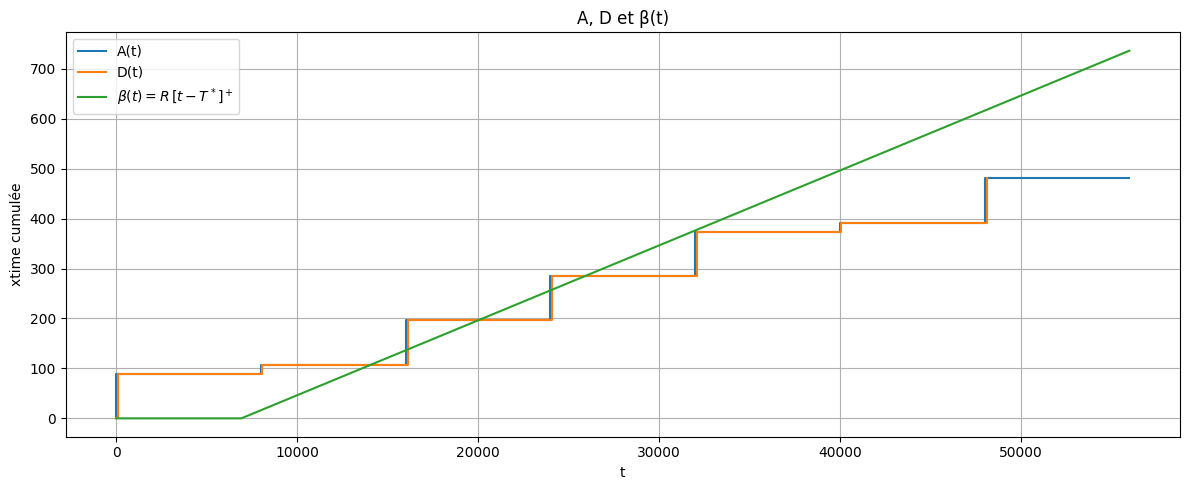

In [61]:
# Bornes temps pour R·t
t_max = max(A_disp[-1][0], D_disp[-1][0])  # bornes selon A et D

# Points pour β(t) = R·[t - T*]^+ : la courbe de service minimale
if T_star < float("inf"):
    beta_pts = [(0.0, 0.0), (T_star, 0.0), (t_max, R * (t_max - T_star))]
else:
    beta_pts = [(0.0, 0.0)]  # courbe vide si T* infini

xA, yA = zip(*A_disp)
xD, yD = zip(*D_disp)
xB, yB = zip(*beta_pts)

plt.figure(figsize=(12,5))

plt.step(xA, yA, where="post", label="A(t)")
plt.step(xD, yD, where="post", label="D(t)")

# β(t) tracée en ligne brisée
plt.plot(xB, yB, label=r"$\beta(t) = R\,[t - T^*]^+$")

plt.xlabel("t")
plt.ylabel("xtime cumulée")
plt.title("A, D et β(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Courbe de service stricte

### Détection des périodes maximales de backlog

In [62]:
def BacklogDetect(A, D):
    """
    Détecte les intervalles de backlog: les périodes (s, t) où A(t) > D(t).
    """

    # Longueurs et indices de parcours pour A et D
    nA, nD = len(A), len(D)
    i, j = 0, 0

    # Temps courant
    t = 0.0

    a, d = A[0][1], D[0][1]
    n = a - d

    # inB = True si on est actuellement dans un intervalle de backlog
    inB = False
    # Liste résultat des intervalles détectés
    B = []

    def slope_seg(P, k):
        """
        Donne la pente du segment k -> k+1
        Si le segment est vertical (dt=0), on renvoie 0 
        """
        if k < len(P) - 1:
            t0, y0 = P[k]; t1, y1 = P[k+1]
            dt = t1 - t0
            return (y1 - y0) / dt if dt > 0.0 else 0.0
        return 0.0

    # Pentes initiales des segments actifs de A et D
    sA = slope_seg(A, i)
    sD = slope_seg(D, j)

    INF = float("inf")

    # On continue tant qu'il reste au moins un segment à parcourir dans A ou D
    while (i < nA - 1) or (j < nD - 1):
        # Prochains ruptures dans A et D (ou +inf si on est au bout)
        tA_next = A[i+1][0] if i < nA - 1 else INF
        tD_next = D[j+1][0] if j < nD - 1 else INF

        # Cas particulier : avaler les points pile au temps courant t
        # (ça gère les ruptures simultanées au même t côté A et/ou D)
        progressed = False
        if i < nA - 1 and tA_next == t:
            i += 1
            a = A[i][1]
            n = a - d
            sA = slope_seg(A, i)
            progressed = True
        if j < nD - 1 and tD_next == t:
            j += 1
            d = D[j][1]
            n = a - d
            sD = slope_seg(D, j)
            progressed = True
        if progressed:
            # Si on vient d'absorber un point exactement à t, on peut potentiellement
            # entrer/sortir de backlog pile à la borne gauche
            if (not inB) and (n > 0.0):
                s = t
                inB = True
            if inB and (n <= 0.0):
                B.append((s, t))
                inB = False
            # On repart au tour suivant sans avancer t (on vient juste d changer l'état à t)
            continue

        # Prochaine rupture globale (celle qui vient le plus tot entre A et D)
        t_next = tA_next if tA_next < tD_next else tD_next
        if t_next == INF:
            break  # plus aucune rupture

        # Différence de pentes sur [t, t_next): sdiff > 0 veut dire que A croît plus vite que D
        sdiff = sA - sD

        # Détection d'entrée de backlog
        # Si on n'est pas en backlog, que n(t) <= 0 (D au moins égal à A) et que A va plus vite (sdiff>0),
        # alors il existe un tau dans [t, t_next] tel que n(tau)=0 -> entrée dans B.
        if (not inB) and (n <= 0.0) and (sdiff > 0.0):
            tau = t + (-n) / sdiff  # interpolation linéaire en temps pour résoudre n(tau)=0
            if tau <= t_next:
                s = tau
                inB = True

        # Détection de sortie de backlog
        # Si on est en backlog, que n(t) >= 0 et que D va plus vite (sdiff<0),
        # alors on quitte le backlog à l'instant où n(tau)=0.
        if inB and (n >= 0.0) and (sdiff < 0.0):
            tau = t + (n) / (-sdiff)  # même idée, mais en sens inverse
            if tau <= t_next:
                B.append((s, tau))
                inB = False

        #  Avancement continu jusqu'à  prochaine rupture 
        dt = t_next - t
        # Sur [t, t_next), A et D évoluent linéairement avec leurs pentes sA et sD :
        a += sA * dt
        d += sD * dt
        n = a - d
        t = t_next

        # Si on est pile sur une rupture de A et/ou D à t_next, on avance les indices et on met à jour les pentes
        if i < nA - 1 and A[i+1][0] == t:
            i += 1
            a = A[i][1]
            sA = slope_seg(A, i)
        if j < nD - 1 and D[j+1][0] == t:
            j += 1
            d = D[j][1]
            sD = slope_seg(D, j)

    return B


In [63]:
BL = BacklogDetect(A_pts, D_pts)
BL[:10]

[(0.0, 106.0),
 (7999.0, 8033.0),
 (16000.0, 16106.0),
 (24000.0, 24106.0),
 (32000.0, 32111.0),
 (39999.0, 40033.0),
 (48002.0, 48108.0),
 (55999.0, 56104.0),
 (64013.0, 64047.0),
 (71999.0, 72104.0)]

## Recherche du meilleur T

In [64]:
def best_T_strict(A, D, R):
    """
    Calcule la latence stricte T* pour un débit R > 0 donné.
    """

    # On commence par détecter les périodes de backlog B depuis A et D
    B = BacklogDetect(A, D)

    assert R > 0.0
    if not B:
        return 0.0

    M = len(D) - 1
    if M < 0:
        return 0.0

    def advance_to_segment(u, j):
        """
        Avance l'indice j pour que D[j] et D[j+1] encadrent u en temps
        """
        while j < M and D[j+1][0] < u:
            j += 1
        return j

    def D_at(u, j):
        """
        Renvoie D(u) par interpolation linéaire, en partant d'un indice j proche.
        - Si on tombe sur un saut vertical (dt=0), on retourne la valeur haute.
        - Sinon, interpolation sur le segment [j, j+1].
        Retourne (valeur, nouvel_indice_j).
        """
        j = advance_to_segment(u, j)
        if j >= M:
            return D[M][1], j
        t0, y0 = D[j]
        t1, y1 = D[j+1]
        dt = t1 - t0
        if dt == 0.0:  # saut vertical
            return y1, j
        y = y0 + (u - t0) * (y1 - y0) / dt
        return y, j

    #  On va utiliser la formule : H(u) = u - D(u)/R.
    #    Pour chaque intervalle de backlog [s, t], on maintient Hmin(u) = min_{x∈[s,u]} H(x).
    #    La latence stricte nécessaire vaut alors max_{u∈[s,t]} (H(u) - Hmin(u)).
    #    On prend le max sur toutes les périodes -> T*.
    B = sorted(B, key=lambda p: p[0])  
    j = 0  
    k = 1  
    Tstar = 0.0

    for (s, t) in B:
        # Positionner j au segment qui couvre puis on calculer D(s)
        j = advance_to_segment(s, j)
        Ds, j = D_at(s, j)

        # Hmin initiale H(s) = s - D(s)/R
        Hmin = s - Ds / R

        # k doit démarrer après j et au moins après s
        k = max(k, j + 1)
        while k <= M and D[k][0] <= s:
            k += 1

        #  Balayage des ruptures t_k de D dans [s, t]
        #    a chaque rupture u = D[k].t on évalue H(u), on met à jour Tstar et Hmin.
        while k <= M and D[k][0] <= t:
            u = D[k][0]
            y = D[k][1]
            H = u - y / R
            diff = H - Hmin  # candidate pour la latence locale

            if diff > Tstar:
                Tstar = diff
            if H < Hmin:
                Hmin = H

            k += 1

            j = min(k - 1, M)

        #  on évalue H(t) à la borne droite de l'intervalle
        #    car t n'est pas forcément un point de rupture de D
        Dt, j = D_at(t, j)
        Ht = t - Dt / R
        diff = Ht - Hmin
        if diff > Tstar:
            Tstar = diff
        if Ht < Hmin:
            Hmin = Ht

    return Tstar


In [65]:
T_star = best_T_strict(A_pts, D_pts, R)
print(f"Latence T* = {T_star}")

Latence T* = 167.0


**Visualisation de A, D et Beta**

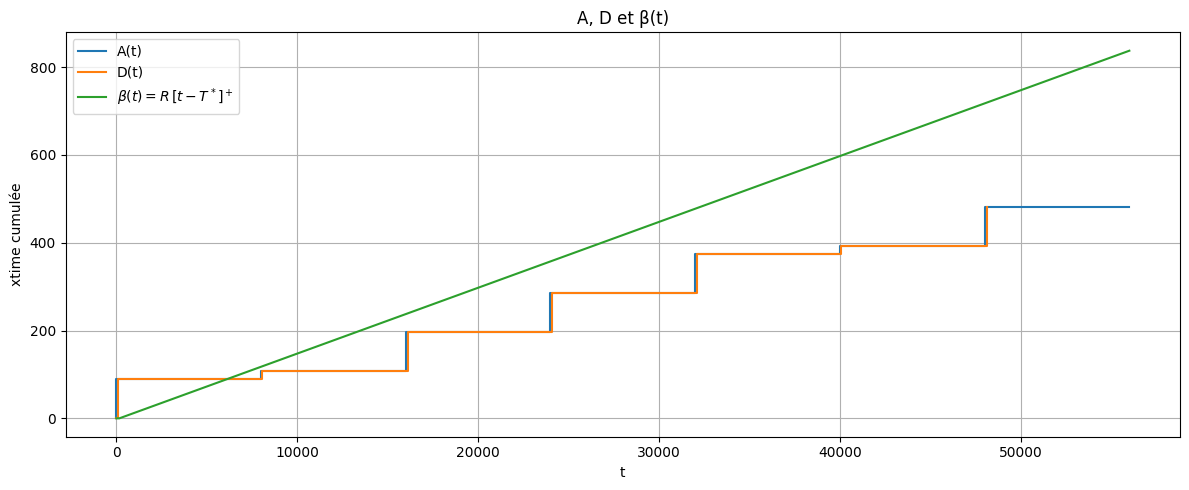

In [66]:
# Bornes temps pour R·t
t_max = max(A_disp[-1][0], D_disp[-1][0])  # bornes selon A et D

# Points pour β(t) = R·[t - T*]^+ : la courbe de service minimale
if T_star < float("inf"):
    beta_pts = [(0.0, 0.0), (T_star, 0.0), (t_max, R * (t_max - T_star))]
else:
    beta_pts = [(0.0, 0.0)]  # courbe vide si T* infini

xA, yA = zip(*A_disp)
xD, yD = zip(*D_disp)
xB, yB = zip(*beta_pts)

plt.figure(figsize=(12,5))

plt.step(xA, yA, where="post", label="A(t)")
plt.step(xD, yD, where="post", label="D(t)")

# β(t) tracée en ligne brisée
plt.plot(xB, yB, label=r"$\beta(t) = R\,[t - T^*]^+$")

plt.xlabel("t")
plt.ylabel("xtime cumulée")
plt.title("A, D et β(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
